# Unsuprevised Machine Learning 

### This $Notebook$ utilises Principal Component Analysis (PCA) - unsupervised learning method and clustering techniques to get insights from a sample dataset.
It's available at https://github.com/vasilnedev/unsupervised-ml.git 

The sample dataset is from the US Arrests Kaggle challenge (https://www.kaggle.com/kurohana/usarrets), described as: “This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.”

The analysis will identify that in 30 'lower-arrests' states, the numbers of all types of arrests are generally twice as little as the respecive numbers within the other 20 'higher-arrests' states. Details about the analysis are explained within each of the 6 sections of this Notebook. Conclusions are made in the last two parts, supported by charts and geographic map. 

## 1. Preparation
In this part the Notbook will:
- load all required libraries
- load the dataset
- explore the data i.e. datatypes, ranges, unique values
- check for missing data and decide on correction actions
- check data ranges and re-scale data if necessary


In [1]:
# Load libraries

# Data containers and manipulation
import numpy  as np
import pandas as pd
from   pandas.api.types import is_numeric_dtype

# Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
%matplotlib inline

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans


In [2]:
# Load data
df = pd.read_csv( 'UsArrests.csv' )
print( f"\nData set dimensions: { df.shape }\n" )
print( "Top few rows:" )
df.head()



Data set dimensions: (50, 5)

Top few rows:


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


City
object
	Null values: 0
	Max repeats: 1 (1 means all values are unique)
	too many unique values

Murder
float64
	Null values: 0
	Max repeats: 2 (1 means all values are unique)


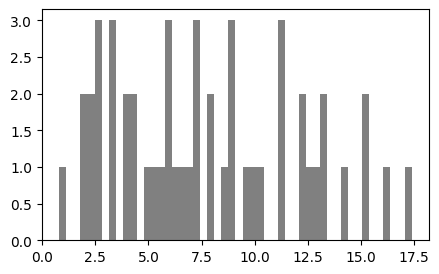


Assault
int64
	Null values: 0
	Max repeats: 3 (1 means all values are unique)


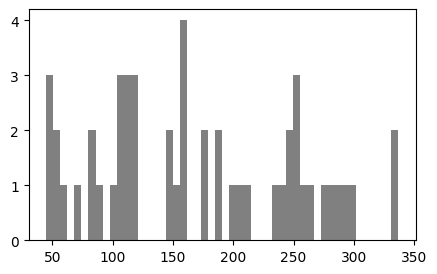


UrbanPop
int64
	Null values: 0
	Max repeats: 4 (1 means all values are unique)


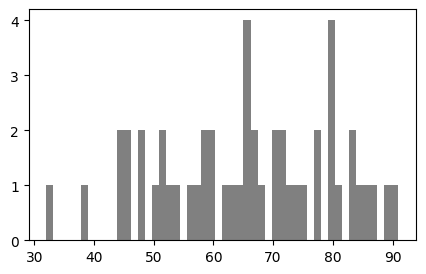


Rape
float64
	Null values: 0
	Max repeats: 2 (1 means all values are unique)


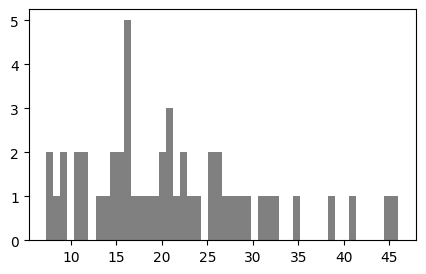

In [3]:
"""
    Define a help function to print pretty list of metadata for each column
"""
def dtypes_and_values( df ):
    for col in df.columns:
        print( col )
        print( str( df[col].dtype ) )
        print( f"\tNull values: { df[ col ].isnull().sum() }" )
        unique_counts = df.pivot_table( columns=[ col ] , aggfunc='size' )
        print( f"\tMax repeats: { unique_counts.max()} (1 means all values are unique)" )
        
        if is_numeric_dtype( df[ col ] ): # For numeric values show histograms
            df[ col ].hist( color='grey' , grid=False , figsize=( 5, 3 ) , bins=50 )
            plt.show()
        else:                             # For non-numeric values show unique values
            unique = df[ col ].unique()
            if len( unique ) <= 10:
                print( '\t', unique )
            else:
                print( '\ttoo many unique values' )

        print()
        
dtypes_and_values( df )


### Notes:
1. Assult and UrbanPop are integer data type, Murder and Rape are float. It will be convenient to make all numeric fields the same type - float.
2. All numeric values are in about the same scale, therefore **no re-scaling is required**.
3. There is no missing data, therefore **no data imputation is required**.
4. City values are not null and all unique, therefore it can be used as **primary index**.
5. Urban Population column will be better placed after the City column


In [4]:
# Change data type from integer to float and set index
df[ 'Assault'  ] = df[ 'Assault'  ].astype(float)
df[ 'UrbanPop' ] = df[ 'UrbanPop' ].astype(float)
df = df.reindex( columns=[ 'City' , 'UrbanPop' , 'Murder' , 'Assault' , 'Rape' ] )
df.set_index( 'City' )
df.head()


,City,UrbanPop,Murder,Assault,Rape
0,Alabama,58.0,13.2,236.0,21.2
1,Alaska,48.0,10.0,263.0,44.5
2,Arizona,80.0,8.1,294.0,31.0
3,Arkansas,50.0,8.8,190.0,19.5
4,California,91.0,9.0,276.0,40.6


## 2. Correlation analysis
Correlation Analysis is a statistical method used to discover relationships between two parameters, and assess how strong that relationship is. The reletaionship measures are between -1 and 1:
- -1 negative correlation - the bigger the firts parameter, the smaller the second is
- 0 no relationship
- +1 positive relationship - the bigger the firts parameter, the bigger the second is

When two parameters have a strong correlation (near to +1 or -1), a linear regression method can be potentially benefitial to give an accurate model. Strong correlations also indicate redundancy in the number of the parameters. 

Pandas' library ``corr`` function returns a matrix of correlation values. Please note that the matrix is symetrical and all elements on the main diagonal are equal to 1. 

This Notbook will use Seaborn's library ``heatmap`` for better visual interpretation. The main diagonal elements will be hidden. The rows/columns with dominant dull (whiteish) colours indicate independent (not correlationg) parameters and contrary, the brighter the colours, the stronger dependecy (correlation) is. 


<AxesSubplot: >

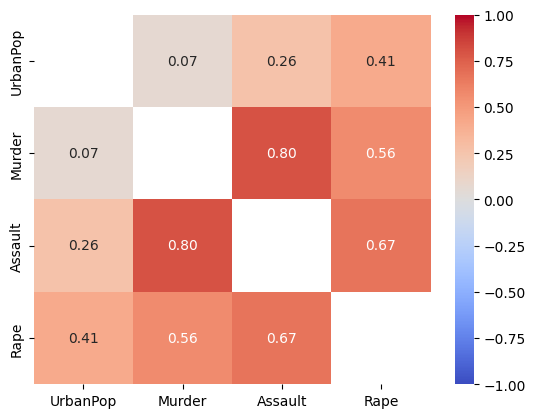

In [5]:
# Create DataFrame - matrix with correlations of all numeric parameters
corr_df = df.select_dtypes( include=np.number ).corr() # Select only numeric fields
labels  = corr_df.columns

# Create masking matrix - a square matrix with 1's in the diagonal elements and 0's as other elements ( Identity matrix ) 
mask_diag = np.zeros( corr_df.shape )
np.fill_diagonal( mask_diag , 1 )

# Create a heatmap of the matrix for better visual presentation
sns.heatmap( corr_df,
             cmap="coolwarm",                     # Use nice colourmap
             mask=mask_diag,                      # Mask the main diagonal
             annot=True, fmt=".2f", linewidth=0,  # Show the values 
             vmin=-1, vmax=1                      # Set min=-1 and max=1 to ensure the whole range of -1 to +1 is covered
) 


### Notes:
1. Visually, the Urban Population parameter is less correlating (has dominant dull colours) than the other 3 parameters. It's highest correlation of 0.41 is with the Rape parameter.
2. All correlations are positive.
3. The strongest correlation of 0.80 is between Assult and Murder columns - this indicates that these two can potentially be used in linear regression analysis.
4. Rape corralets almost equally with all the other parameters with correlation values of 0.41, 0.56 and 0.67.
5. Overall, the four parameters can be reduced to two independent dimensions.


## 3. Principal Components Analysis (PCA) 
As expalined in Wikipedia (see https://en.wikipedia.org/wiki/Principal_component_analysis) - "Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data."

In the case of US Arrests Kaggle challenge dataset, the dimensions are not particularly large; however, there is a benefit of reducing the dimensions to minimum number for better exploration.


<AxesSubplot: >

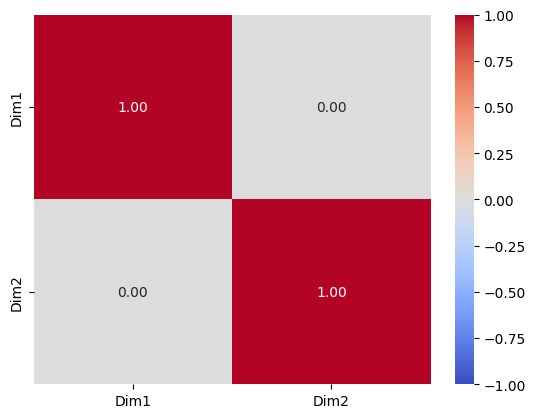

In [6]:
# Select two Primary Components via PCA method

dimensions = 2 # selected number of dimensions
pca = PCA( n_components=dimensions ) 
X = df.drop( [ "City" ] , axis=1 ).values # Drop the index as it's non-numeric
X_std = MinMaxScaler().fit_transform( X ) # Scale the numbers 
X_pca = pca.fit_transform( X_std )

pca_df = pd.DataFrame( X_pca , columns=[ "Dim1" , "Dim2" ] ) # Create new Data Frame with the new dimensions

# Create a heatmap to ensure that the Primary Components are not correlating to each other - they shall form Identity matrix
sns.heatmap( pca_df.corr(),
             cmap="coolwarm",                     # Use nice colourmap
             annot=True, fmt=".2f", linewidth=0,  # Show the values 
             vmin=-1, vmax=1                      # Set min=-1 and max=1 to ensure the whole range of -1 to +1 is covered
) 


Dim1
float64
	Null values: 0
	Max repeats: 1 (1 means all values are unique)


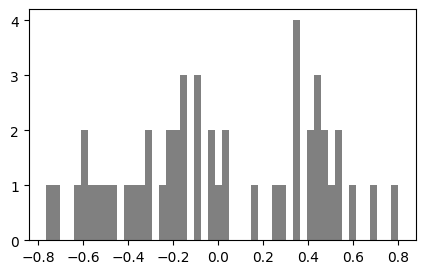


Dim2
float64
	Null values: 0
	Max repeats: 1 (1 means all values are unique)


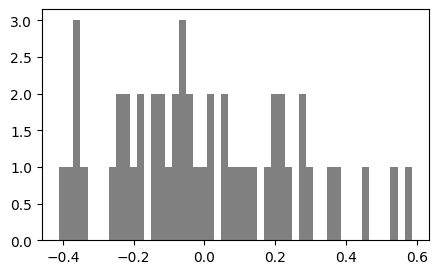

In [7]:
# Check the data for the new dimensions
dtypes_and_values( pca_df )


<AxesSubplot: title={'center': 'New dimensions scatter plot'}, xlabel='Dim1', ylabel='Dim2'>

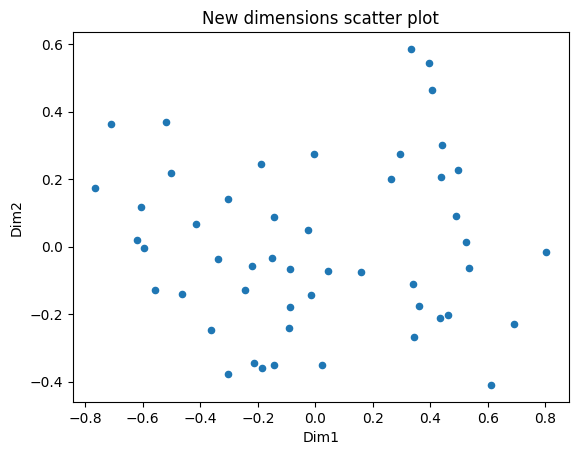

In [8]:
# Scatter plot of the new dimensions
pca_df.plot.scatter( x='Dim1' , y='Dim2' , title='New dimensions scatter plot' )


### Notes:
1. The new dimensions are evenly scattered and therefore are good candidate for clustering analysis in the next two sections.


## 4. Hierarchical clustering
This method seeks to build a hierarchy of clusters, generally using two categories:
**Agglomerative:** This is a "bottom-up" approach: Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
**Divisive:** This is a "top-down" approach: All observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.
Also, linkage methods define proximity between any two clusters at every step. Three methods will be used:
- **single linkage** or nearest neighbour. Proximity between two clusters is the proximity between their two closest objects. 
- **complete linkage** or farthest neighbour. Proximity between two clusters is the proximity between their two most distant objects. 
- **average linkage** (UPGMA). Proximity between two clusters is the arithmetic mean of all the proximities between the objects of one, on one side, and the objects of the other, on the other side. 

The results are presented in dendrograms.


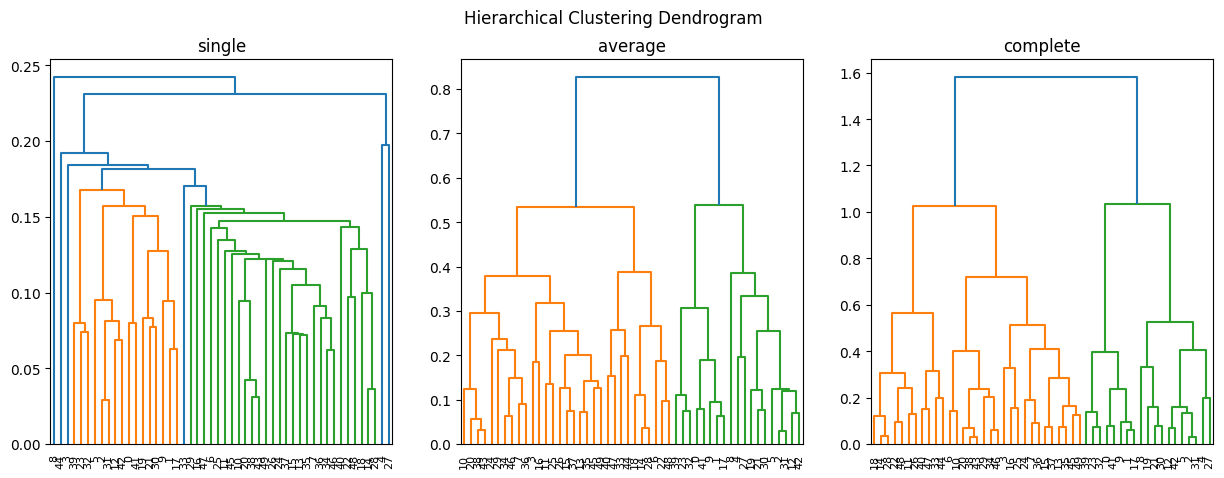

In [9]:
model = AgglomerativeClustering( distance_threshold=0 , n_clusters=None )
model = model.fit( pca_df )

linkage_methods=[ 'single' , 'average' , 'complete' ]

fig, ( ax ) = plt.subplots( 1 , len( linkage_methods ) , figsize=(15, 5) )
fig.suptitle('Hierarchical Clustering Dendrogram')
for i , method in enumerate( linkage_methods ):
    ax[ i ].set_title( method )
    dendrogram( linkage( pca_df , method=method ), labels=pca_df.index , ax=ax[ i ] )
plt.show()


### Notes:
1. Everage and complete linkage methods of Agglomerative clustering show good split of the dataset in two clusters at the highest level and then each two split in two sub-clusters.

## 5. K-means clustering
This method is described in Wikibedia as "k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition an observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids."

In this expolration will use K-means clustering to split the dataset for the top level - as seen in the Hierarchial clustering above.

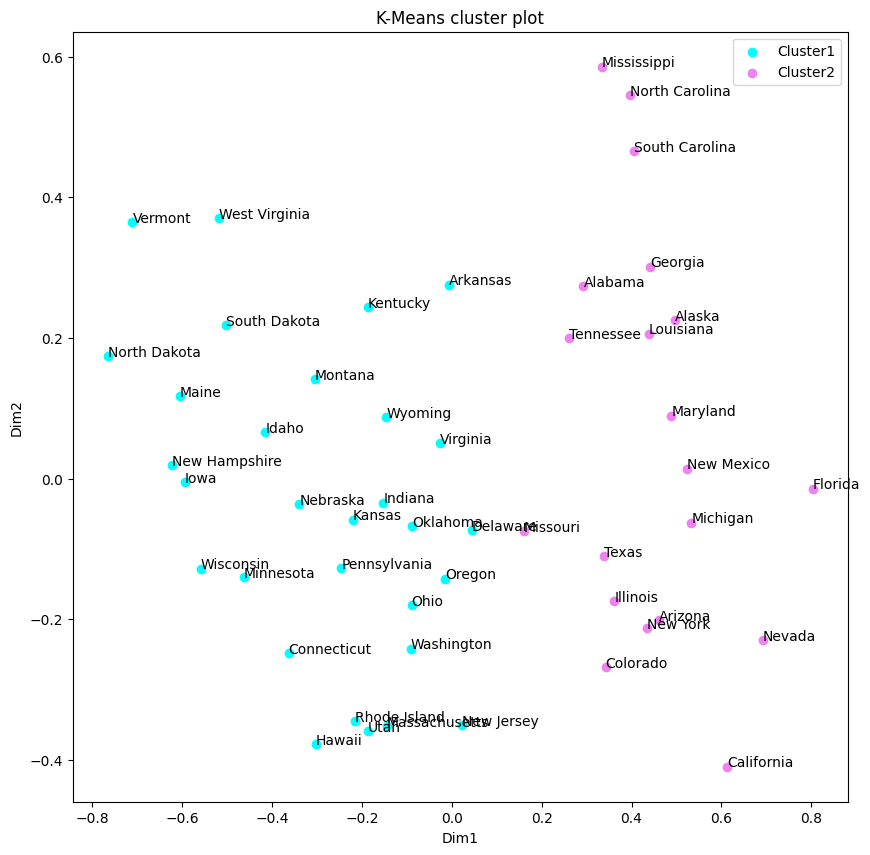

In [10]:
# We extract the first two components
x = pca_df[ 'Dim1' ]
y = pca_df[ 'Dim2' ]
cities = df[ 'City' ]

# Fit k-means
k=2 # two clusters - as seen in the Hierarchial clustering above, the dataset splits in two at the top level
cluster_labels  = [ 'Cluster1' , 'Cluster2' , 'Cluster3' , 'Cluster4' ]
cluster_colours = [ 'aqua' , 'violet' , 'blue' , 'red' ]

# Calculate k means clusters
kmeans = KMeans( n_clusters=k , init='k-means++' , random_state=123 , n_init='auto' )
cluster_codes = kmeans.fit_predict( pca_df )

# Plot clusters
fig, ax = plt.subplots( figsize=( 10 , 10 ) )
for i in range( 0 , k ):
    ax.scatter( x[ cluster_codes == i ] , y[ cluster_codes == i ] , c=cluster_colours[ i ] , label=cluster_labels[i] ) 
for i in range( 0 , len( x ) ):
    ax.annotate( cities[i] , ( x[i] , y[i] ) )
    
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim1")
ax.set_ylabel("Dim2")
ax.legend()
plt.show()


In [11]:
# Correlation between Dim1/Dim2 and the original parameters 
print( pca.components_ )


[[ 0.22955857  0.54750034  0.64593081  0.47991627]
 [-0.8804443   0.38795783  0.15212429 -0.22619628]]


In [12]:
# Count the elements in each cluster
np.unique( cluster_codes , return_counts=True )


(array([0, 1], dtype=int32), array([30, 20]))

### Interpretation:
the PCA components vectors indicate that:
- Dim1 is calculated predominantly from the sum of all arrest parameters (coefficients 0.54, 0.64 and 0.48), hence it is an indicator of the **total arrests per capita**
- Dim2 is calculated predomiantly from the population (coeficient -0.88) and therefore it is an indicator of the **urban population**

The scatter plot above shows that the clustering splits well the dataset along Dim1( total arrets per capita ) and that the urban population( Dim2 ) does not effect the top level clusters.

The analysis identified two clusters:
- **lower arrests** ( total arrests per capita - see the aqua colour dots above ). This cluster includes 30 states.
- **higher arrests** ( total arrests per capita - see the violet colour dits above ). This cluster includes 20 states.


In [13]:
# Define and set a new column - Total Arrests Per Capita (TAPC) and set its value from the K-means clustering results
df[ 'TAPC' ] = np.where( cluster_codes == 0 , 'lower arrests states' , 'higher arrests states' ) 
df.head()


,City,UrbanPop,Murder,Assault,Rape,TAPC
0,Alabama,58.0,13.2,236.0,21.2,higher arrests states
1,Alaska,48.0,10.0,263.0,44.5,higher arrests states
2,Arizona,80.0,8.1,294.0,31.0,higher arrests states
3,Arkansas,50.0,8.8,190.0,19.5,lower arrests states
4,California,91.0,9.0,276.0,40.6,higher arrests states


array([<AxesSubplot: title={'center': 'Murder'}, xlabel='[TAPC]'>,
       <AxesSubplot: title={'center': 'Rape'}, xlabel='[TAPC]'>],
      dtype=object)

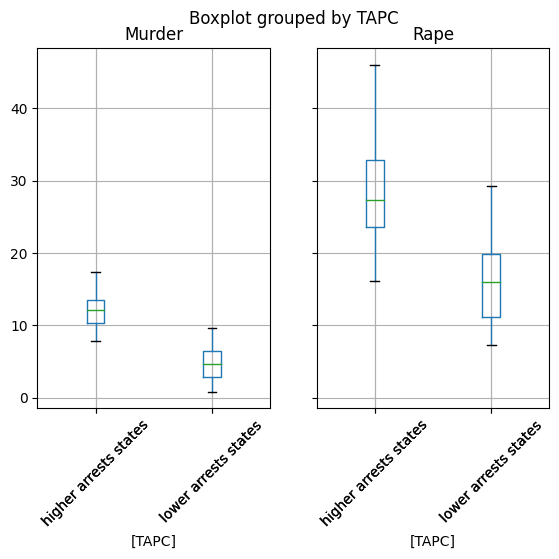

In [14]:
# Box plot based on the clustering
df.boxplot( column=[ 'Murder' , 'Rape' ] , by=[ 'TAPC' ] , rot=45 )


<AxesSubplot: title={'center': 'Assault'}, xlabel='[TAPC]'>

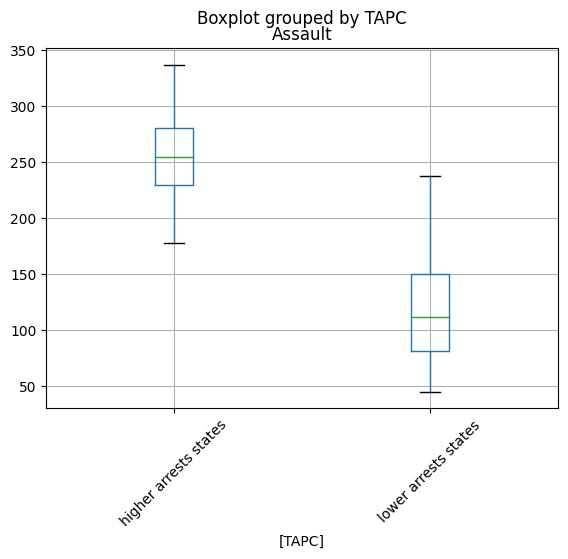

In [15]:
df.boxplot( column=[ 'Assault' ] , by=[ 'TAPC' ] , rot=45 )


## Conclusion:

## The data shows that in 30 'lower-arrests' states, the numbers of all types of arrests are generally twice as little as the respecive numbers within 20 'higher-arrests' states. 

## 6. Geomap plot
For this dataset is appropriate to use geomap presentation. It this Notebook will use the method described in https://jcutrer.com/python/learn-geopandas-plotting-usmaps 

In [16]:
# Load US map
states = geopandas.read_file( 'us_map/usa-states-census-2014.shp' )


In [17]:
# Compare crime arrests dataset and the states map dataset
df[ ~df[ 'City' ].isin( states[ 'NAME' ] ) ]


,City,UrbanPop,Murder,Assault,Rape,TAPC
1,Alaska,48.0,10.0,263.0,44.5,higher arrests states
10,Hawaii,83.0,5.3,46.0,20.2,lower arrests states


### Notes:
Alaska and Hawaii will not be displaied on the geomap.


In [18]:
# Add Cluster column and arrests to states DataFrame

cluster_colour_col=[]
murders=[]
assaults=[]
rapes=[]

for state_name in states[ 'NAME' ]:
    if state_name == 'District of Columbia': # Exception for Washington - DC
        city = 'Washington'
    else:
        city = state_name
    i = df[ df[ 'City' ] == city ].index[0]
    cluster_colour_col.append( cluster_colours[ cluster_codes[ i ] ] )
    row = df[ df[ 'City' ] == city ]
    murders.append( int( row[ 'Murder' ].values[0] ))
    assaults.append( int( row[ 'Assault' ].values[0] ))
    rapes.append  ( int( row[ 'Rape' ].values[0] ))
    
states[ 'CLUSTER_COLOUR' ] = cluster_colour_col
states[ 'Murder'  ] = murders
states[ 'Assault' ] = assaults
states[ 'Rape'    ] = rapes
states.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry,CLUSTER_COLOUR,Murder,Assault,Rape
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...",violet,9,276,40
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...",aqua,4,145,26
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",violet,15,335,31
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...",violet,17,211,25
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117....",aqua,2,120,14


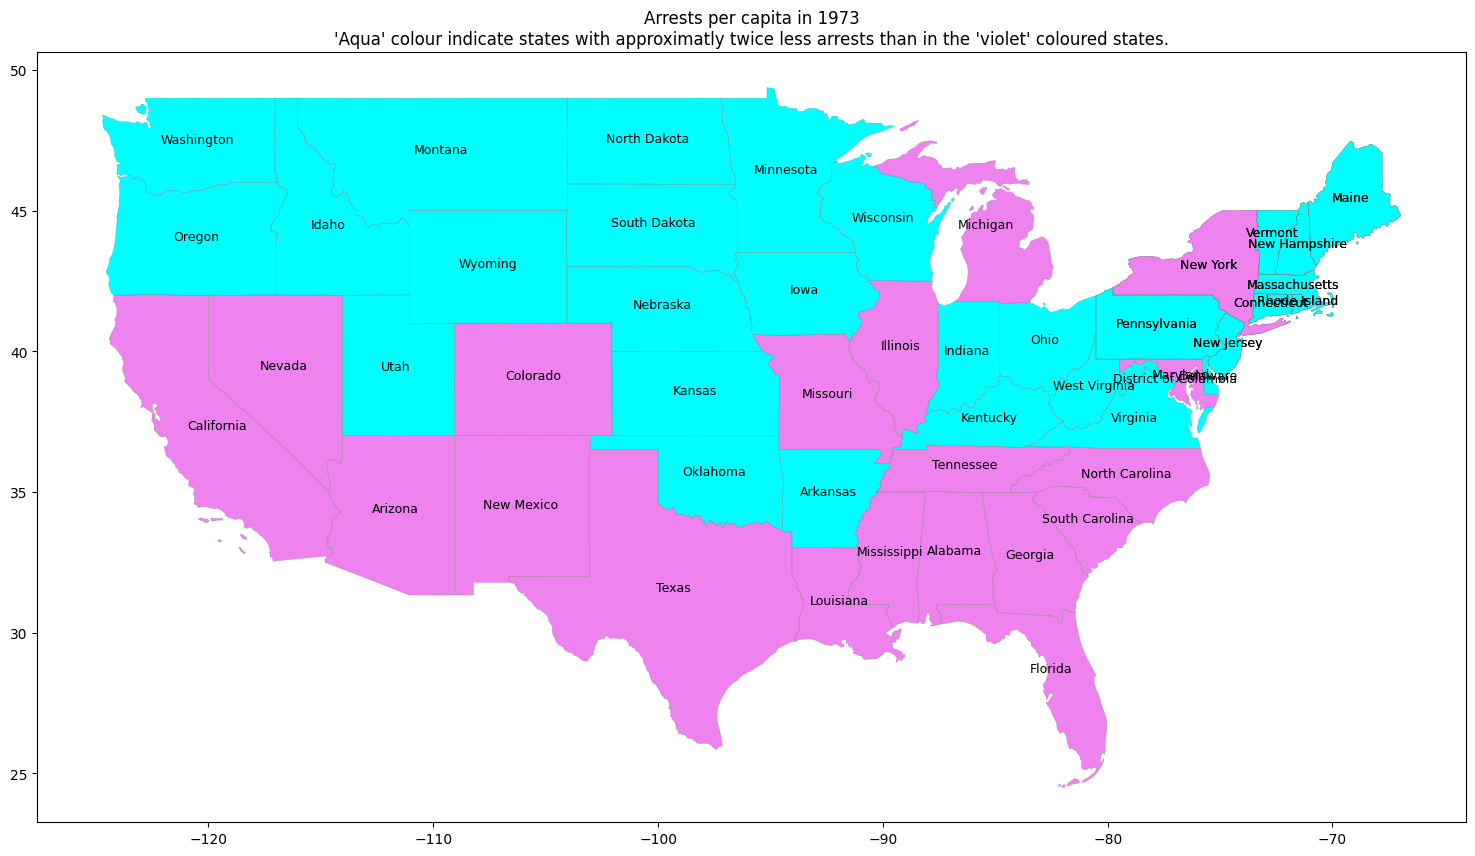

In [19]:
fig = plt.figure( 1, figsize=( 20 , 10 ) ) 
ax = fig.add_subplot()
states.apply( lambda x: ax.annotate( 
    text=f"{ x.NAME }" , 
    xy=x.geometry.centroid.coords[0] , 
    ha='center' , 
    fontsize=9 
) , axis=1 )

states.boundary.plot( ax=ax , color='Grey' , linewidth=.2 )
states.plot( ax=ax , color=states['CLUSTER_COLOUR'] , figsize=( 12 , 12 ) )
plt.title( "Arrests per capita in 1973\n'Aqua' colour indicate states with approximatly twice less arrests than in the 'violet' coloured states." )
plt.show()


### Notes:
Alaska and Hawaii are not shown on the map

# Conclusion
## Using data analytic clustering, this Notebook identified that in 1973 the total arrests per capita were twice more in 20 southern states than in 30 northern states - with some exceptions show on the map above. 
